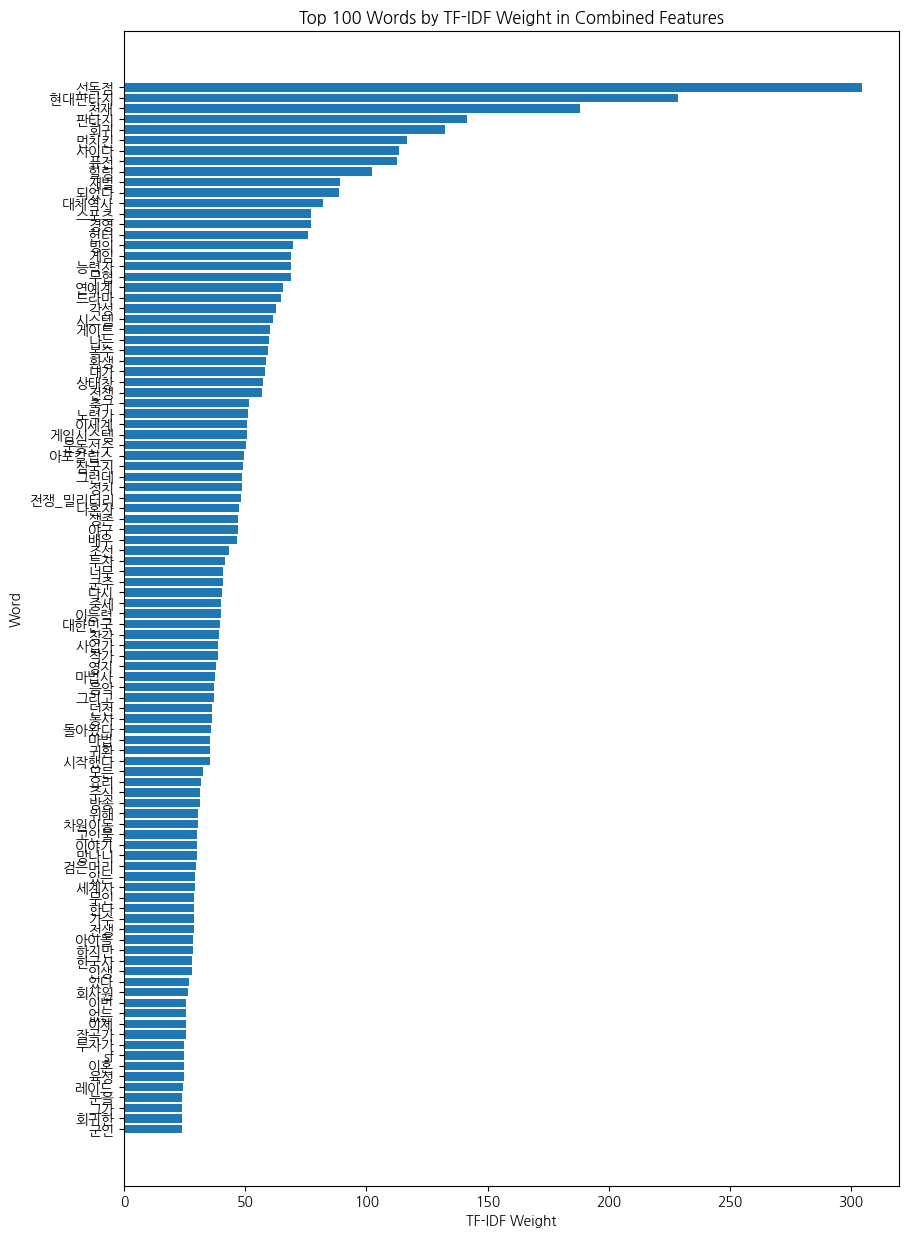

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rc('font', family='NanumGothic')

# CSV 파일 불러오기
df = pd.read_csv('munpia_novel_data.csv')

# 결합된 특성 열 생성
df['combined_features'] = df['title'] + ' ' + df['author'] + ' ' + df['intro'] + ' ' + df['tags']
df['combined_features'] = df['combined_features'].fillna('')  # 결측값을 공백으로 대체

# TF-IDF 벡터화
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

# 단어와 그에 해당하는 TF-IDF 가중치 추출
word_features = tfidf.get_feature_names_out()
tfidf_weights = tfidf_matrix.sum(axis=0).A1  # 모든 문서에서의 TF-IDF 합계

# 단어 가중치를 데이터프레임으로 변환
word_tfidf_df = pd.DataFrame({'word': word_features, 'tfidf': tfidf_weights})
word_tfidf_df = word_tfidf_df.sort_values(by='tfidf', ascending=False).head(100)  # 상위 100개 단어 추출

# 시각화
plt.figure(figsize=(10, 15))
plt.barh(word_tfidf_df['word'], word_tfidf_df['tfidf'])
plt.xlabel('TF-IDF Weight')
plt.ylabel('Word')
plt.title('Top 100 Words by TF-IDF Weight in Combined Features')
plt.gca().invert_yaxis()  # y축 순서 반전
plt.show()


#### 불용어는 : 선독점, 되었다, 그리고 등.

In [ ]:
from flask import Flask, request, jsonify, render_template
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack

# Flask 앱 생성
app = Flask(__name__)

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거

# 결측치 제거
data.dropna(subset=['intro'], inplace=True)

# 한국어 불용어 리스트를 설정
stop_words = ["를", "의", "선", "독점", "선독점", "독점작", "이번", "들", "등", "수", "이", "부", "판", 
              "뿐", "여자", "남자", "그", "것", "나", "그녀", "속", "시작", "내", "거", "중"]

# 가중치 설정 (예: title: 0.1, author: 0.1, intro: 0.3, tags: 0.3, genre: 0.2)
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# 각 컬럼에 대해 TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_author = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words=stop_words, max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

# 추천 함수 정의
def recommend_novel(title, num_recommendations=10):
    if title not in data['title'].values:
        return []
    
    idx = data.index[data['title'] == title][0]
    tfidf_vector = tfidf_matrix[idx]
    
    # 유사한 웹소설 찾기
    distances, indices = knn_model.kneighbors(tfidf_vector, n_neighbors=num_recommendations + 1)
    
    # 추천 결과 정리
    recommendations = []
    for i in range(1, len(indices.flatten())):  # 자신 제외
        similar_idx = indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similar_author = data.iloc[similar_idx]['author']
        similar_intro = data.iloc[similar_idx]['intro']
        similarity_score = 1 - distances.flatten()[i]
        recommendations.append({
            "rank": i,
            "title": similar_title,
            "author": similar_author,
            "intro": similar_intro,
            "similarity": round(similarity_score, 2)
        })
    return recommendations

# 자동완성 API 추가
@app.route('/autocomplete', methods=['GET'])
def autocomplete():
    query = request.args.get('query', '').lower()
    if not query:
        return jsonify([])

    # 입력된 검색어를 포함하는 제목 필터링
    suggestions = data[data['title'].str.lower().str.contains(query)]['title'].tolist()
    return jsonify(suggestions[:10])  # 최대 10개 반환

# Flask 라우팅
@app.route('/')
def index():
    return render_template('index.html')  # HTML 파일 렌더링

@app.route('/recommend', methods=['POST'])
def recommend():
    title = request.form.get('title')  # 사용자가 입력한 제목
    if not title:
        return jsonify({"error": "Title is required"}), 400
    
    recommendations = recommend_novel(title)
    if not recommendations:
        return jsonify({"error": f"No recommendations found for '{title}'"}), 404
    
    return jsonify({"title": title, "recommendations": recommendations})

if __name__ == '__main__':
    app.run(debug=False)


# 행렬분해 형태의 flask 앱

In [5]:
from flask import Flask, request, jsonify, render_template
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import hstack

# Flask 앱 생성
app = Flask(__name__)

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거
data.dropna(subset=['intro'], inplace=True)  # 결측치 제거

# 한국어 불용어 리스트 설정
stop_words = ["를", "의", "선", "독점", "나는", "내가", "그리고", "그런데", "위해", "되어", "그의", "그는", "되었다", 
              "있었다", "있다", "없다", "선독점", "독점작", "그녀", "위해"]

# 가중치 설정
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_author = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words=stop_words, max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# SVD로 차원 축소
svd = TruncatedSVD(n_components=100, random_state=42)
latent_matrix = svd.fit_transform(tfidf_matrix)

# 추천 함수 정의
def recommend_novel(title, num_recommendations=10):
    if title not in data['title'].values:
        return []
    
    idx = data.index[data['title'] == title][0]
    query_vector = latent_matrix[idx].reshape(1, -1)
    
    # 코사인 유사도 계산
    similarities = cosine_similarity(query_vector, latent_matrix).flatten()
    similar_indices = similarities.argsort()[::-1][1:num_recommendations + 1]
    
    # 추천 결과 정리
    recommendations = []
    for i, similar_idx in enumerate(similar_indices, 1):
        recommendations.append({
            "rank": i,
            "title": data.iloc[similar_idx]['title'],
            "author": data.iloc[similar_idx]['author'],
            "intro": data.iloc[similar_idx]['intro'],
            "similarity": round(similarities[similar_idx], 2)
        })
    return recommendations

# 자동완성 API 추가
@app.route('/autocomplete', methods=['GET'])
def autocomplete():
    query = request.args.get('query', '').lower()
    if not query:
        return jsonify([])

    # 입력된 검색어를 포함하는 제목 필터링
    suggestions = data[data['title'].str.lower().str.contains(query)]['title'].tolist()
    return jsonify(suggestions[:10])  # 최대 10개 반환

# Flask 라우팅
@app.route('/')
def index():
    return render_template('index.html')  # HTML 파일 렌더링

@app.route('/recommend', methods=['POST'])
def recommend():
    title = request.form.get('title')  # 사용자가 입력한 제목
    if not title:
        return jsonify({"error": "Title is required"}), 400
    
    recommendations = recommend_novel(title)
    if not recommendations:
        return jsonify({"error": f"No recommendations found for '{title}'"}), 404
    
    return jsonify({"title": title, "recommendations": recommendations})

if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Nov/2024 23:24:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:16] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 23:24:16] "GET /static/scripts.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 23:24:16] "GET /static/images/munpia-logo2.png HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 23:24:18] "GET /autocomplete?query=ㅅ HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:18] "GET /autocomplete?query=서 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:18] "GET /autocomplete?query=선 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:18] "GET /autocomplete?query=선ㄷ HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:18] "GET /autocomplete?query=선 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:18] "GET /autocomplete?query=선도 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:18] "GET /autocomplete?query=선독 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:24:19] "GET /autocomplete?query=선독ㅈ HTTP/1.1" 

# tf-idf+행렬 분해 + knn

In [4]:
from flask import Flask, request, jsonify, render_template
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack

# Flask 앱 생성
app = Flask(__name__)

# 데이터 불러오기
data = pd.read_csv('munpia_novel_data.csv')

# 필요 컬럼 선택
data = data[['title', 'author', 'intro', 'tags', 'genre']]
data.drop_duplicates(subset=['title'], inplace=True)  # 중복된 제목 제거
data.dropna(subset=['intro'], inplace=True)  # 결측치 제거

# 한국어 불용어 리스트 설정
stop_words = ["를", "의", "선", "독점", "나는", "내가", "그리고", "그런데", "위해", "되어", "그의", "그는", "되었다", 
              "있었다", "있다", "없다", "선독점", "독점작", "그녀", "위해"]

# 가중치 설정
weight_title = 0.1
weight_author = 0.1
weight_intro = 0.3
weight_tags = 0.3
weight_genre = 0.2

# TF-IDF 벡터화
vectorizer_title = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_author = TfidfVectorizer(stop_words=stop_words, max_features=500)
vectorizer_intro = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_tags = TfidfVectorizer(stop_words=stop_words, max_features=3000)
vectorizer_genre = TfidfVectorizer(stop_words=stop_words, max_features=2000)

tfidf_title = vectorizer_title.fit_transform(data['title']) * weight_title
tfidf_author = vectorizer_author.fit_transform(data['author'].fillna('')) * weight_author
tfidf_intro = vectorizer_intro.fit_transform(data['intro']) * weight_intro
tfidf_tags = vectorizer_tags.fit_transform(data['tags'].fillna('')) * weight_tags
tfidf_genre = vectorizer_genre.fit_transform(data['genre'].fillna('')) * weight_genre

# 각 TF-IDF 벡터 결합
tfidf_matrix = hstack([tfidf_title, tfidf_author, tfidf_intro, tfidf_tags, tfidf_genre])

# SVD로 차원 축소
svd = TruncatedSVD(n_components=100, random_state=42)
latent_matrix = svd.fit_transform(tfidf_matrix)

# KNN 모델 학습
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(latent_matrix)

# 추천 함수 정의
def recommend_novel(title, num_recommendations=10):
    if title not in data['title'].values:
        return []
    
    idx = data.index[data['title'] == title][0]
    query_vector = latent_matrix[idx].reshape(1, -1)
    
    # KNN을 통한 유사한 소설 찾기
    distances, indices = knn_model.kneighbors(query_vector, n_neighbors=num_recommendations + 1)
    
    # 추천 결과 정리
    recommendations = []
    for i in range(1, len(indices.flatten())):  # 자신 제외
        similar_idx = indices.flatten()[i]
        similar_title = data.iloc[similar_idx]['title']
        similar_author = data.iloc[similar_idx]['author']
        similar_intro = data.iloc[similar_idx]['intro']
        similarity_score = 1 - distances.flatten()[i]
        recommendations.append({
            "rank": i,
            "title": similar_title,
            "author": similar_author,
            "intro": similar_intro,
            "similarity": round(similarity_score, 2)
        })
    return recommendations

# 자동완성 API 추가
@app.route('/autocomplete', methods=['GET'])
def autocomplete():
    query = request.args.get('query', '').lower()
    if not query:
        return jsonify([])

    # 입력된 검색어를 포함하는 제목 필터링
    suggestions = data[data['title'].str.lower().str.contains(query)]['title'].tolist()
    return jsonify(suggestions[:10])  # 최대 10개 반환

# Flask 라우팅
@app.route('/')
def index():
    return render_template('index.html')  # HTML 파일 렌더링

@app.route('/recommend', methods=['POST'])
def recommend():
    title = request.form.get('title')  # 사용자가 입력한 제목
    if not title:
        return jsonify({"error": "Title is required"}), 400
    
    recommendations = recommend_novel(title)
    if not recommendations:
        return jsonify({"error": f"No recommendations found for '{title}'"}), 404
    
    return jsonify({"title": title, "recommendations": recommendations})

if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Nov/2024 23:22:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:11] "GET /static/styles.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 23:22:11] "GET /static/scripts.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 23:22:11] "GET /static/images/munpia-logo2.png HTTP/1.1" 304 -
127.0.0.1 - - [28/Nov/2024 23:22:13] "GET /autocomplete?query=ㅅ HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:13] "GET /autocomplete?query=서 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:13] "GET /autocomplete?query=선 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:14] "GET /autocomplete?query=선ㄷ HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:14] "GET /autocomplete?query=선 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:14] "GET /autocomplete?query=선도 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:14] "GET /autocomplete?query=선독 HTTP/1.1" 200 -
127.0.0.1 - - [28/Nov/2024 23:22:14] "GET /autocomplete?query=선독ㅈ HTTP/1.1" 